In [1]:
#@title Install arviz
# !pip3 install arviz

In [2]:
import arviz as az
import pystan, pickle
import os
# os.environ['STAN_NUM_THREADS'] = "4"
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import networkx as nx
# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# %matplotlib inline

In [3]:
stancode = """
functions {
            real[] SIR(real t,  // time
            real[] u,           // system state {infected,cases,susceptible}
            real[] theta,       // parameters 
            real[] x_r,
            int[] x_i) {

            real du_dt[2];
        
            real beta = theta[1];
            real sigmac = theta[2];
            real sigmar = theta[3];
            real sigmad =  theta[4];
            real q = theta[5]; 
            real f = theta[6]; 
            real mbase = theta[7]; 
            real mlocation = theta[8]; 
            real mrate = theta[9]; 
            real cmax = theta[10];
            real c50 = theta[11];
            
            real I = u[1];  # unknown infected
            real C = u[2];  # cases
            
            beta *= mbase + (1-mbase)/(1 + exp(mrate*(t - mlocation)));
            sigmac *= 1 + cmax*t/(c50+t);
            
            
            du_dt[1] = beta*(I+q*C) - sigmac*I - f*(sigmar+sigmad)*I; //I
            du_dt[2] = sigmac*I - (sigmar+sigmad)*C; //C
            
            return du_dt;
          }
        }

        data {
          int<lower = 1> n_obs;       // number of days observed
          int<lower = 1> n_theta;     // number of model parameters
          int<lower = 1> n_difeq;     // number of differential equations for yhat
          int<lower = 1> n_ostates;     // number of observed states
          real<lower = 1> n_scale;       // scale to match observed scale
          int y[n_obs,n_ostates];           // data, per-day-tally [cases,recovered,death]
          real t0;                // initial time point 
          real tm; //start day of mitigation
          real ts[n_obs];         // time points that were observed
          }

        transformed data {
            real x_r[0];
            int x_i[0];           
        }

        parameters {
            real<lower = 0> theta[n_theta]; // model parameters 
        }

        transformed parameters{
            real u[n_obs, n_difeq]; // solution from the ODE solver
            real u_init[n_difeq];     // initial conditions for fractions
            
            real beta = theta[1];
            real sigmac = theta[2];
            real sigmar = theta[3];
            real sigmad =  theta[4];
            real q = theta[5]; 
            real f = theta[6]; 
            real mbase = theta[7]; 
            real mlocation = theta[8]; 
            real mrate = theta[9]; 
            real cmax = theta[10];
            real c50 = theta[11];
            real theta_init = theta[12];
            
            real sigmac2;
            
            real lambda[n_obs,3]; //poisson parameter [cases, deaths, recovered]

            
                        
            u_init[1] = theta_init/n_scale; // I
            u_init[2] = y[1,1]/n_scale; //C
                     
            //print(theta)
            u = integrate_ode_rk45(SIR, u_init, t0, ts, theta, x_r, x_i);
            
            //lambda
            sigmac2 = sigmac*(1 + cmax*1/(c50+1));
            lambda[1,1] = .5*(u[1,1]+u_init[1])*sigmac2*n_scale; //C: cases sigma_c*\int I
            lambda[1,2] = .5*(u[1,2]+u_init[2])*sigmar*n_scale; //R: recovered sigma_r*\int C
            lambda[1,3] = .5*(u[1,2]+u_init[2])*sigmad*n_scale; //D: dead sigma_d * \int C
        
            for (i in 2:n_obs){
                sigmac2 = sigmac*(1 + cmax*0.5*i/(c50+0.5*i));
                lambda[i,1] = .5*(u[i,1]+u[i-1,1])*sigmac2*n_scale; //C: cases sigma_c*\int_{interval} I
                lambda[i,2] = .5*(u[i,2]+u[i-1,2])*sigmar*n_scale; //R: recovered sigma_r*C
                lambda[i,3] = .5*(u[i,2]+u[i-1,2])*sigmad*n_scale; //D: dead
            
            }
  
        }

        model {
  
            //priors
            
            //for (i in 1:n_theta){theta[1] ~ lognormal(log(0.1),10);};
            //theta[5] ~ lognormal(log(0.25),10);
            
            
            //real beta = theta[1];
            //real sigmac = theta[2];
            //real sigmar = theta[3];
            //real sigmad =  theta[4];
            //real q = theta[5]; 
            //real f = theta[6]; 
            //real mbase = theta[7]; 
            //real mlocation = theta[8]; 
            //real mrate = theta[9]; 
            //real cmax = theta[10];
            //real c50 = theta[11];
            
            // [0.25,
            //0.1,
            //0.01,
            //0.01,
            //0.01,
            //1.0,
            //0.1,
            //1.0,
            //1.0,
            //0.1,
            //10.0,
            //1.0]

            theta[1] ~ lognormal(log(0.25),1); //beta 
            theta[2] ~ lognormal(log(0.1),1); //sigmac
            theta[3] ~ lognormal(log(0.01),1); //sigmar
            theta[4] ~ lognormal(log(0.01),1); //sigmad
            theta[5] ~ lognormal(log(0.01),1); //q
            theta[6] ~ lognormal(log(1),1); //f
            theta[7] ~ lognormal(log(0.1),1); //mbase  
            theta[8] ~ lognormal(log(tm),5); //mlocation 
            theta[9] ~ lognormal(log(1),5); //mrate
            theta[10] ~ lognormal(log(0.1),1);//cmax 
            theta[11] ~ lognormal(log(10),1);//c50 
            theta[12] ~ lognormal(log(1),0.1);// theta_init 

          
            //likelihood
            //lambda[1,1] = .5*(u[1,1]+u_init[1])*sigmac*n_scale; //C: cases sigma_c*\int I
            //lambda[1,2] = .5*(u[1,2]+u_init[2])*sigmar*n_scale; //R: recovered sigma_r*\int C
            //lambda[1,3] = .5*(u[1,2]+u_init[2])*sigmad*n_scale; //D: dead sigma_d * \int C
        
            target += poisson_lpmf(y[1,1]|max([lambda[1,1],0.0])); //C
            target += poisson_lpmf(y[1,2]|max([lambda[1,2],0.0])); //R
            target += poisson_lpmf(y[1,3]|max([lambda[1,3],0.0])); //D

            
            for (i in 2:n_obs){
                //lambda[i,1] = .5*(u[i,1]+u[i-1,1])*sigmac*n_scale; //C: cases sigma_c*\int_{interval} I
                //lambda[i,2] = .5*(u[i,2]+u[i-1,2])*sigmar*n_scale; //R: recovered sigma_r*C
                //lambda[i,3] = .5*(u[i,2]+u[i-1,2])*sigmad*n_scale; //D: dead
            
                target += poisson_lpmf(y[i,1]|max([lambda[i,1],0.0])); //C
                target += poisson_lpmf(y[i,2]|max([lambda[i,2],0.0])); //R
                target += poisson_lpmf(y[i,3]|max([lambda[i,3],0.0])); //D
            }

        }

        generated quantities {
        
            real ll_; // log-likelihood for model
         
            //likelihood
            ll_ = poisson_lpmf(y[1,1]|max([lambda[1,1],0.0]));
            ll_ += poisson_lpmf(y[1,2]|max([lambda[1,2],0.0]));
            ll_ += poisson_lpmf(y[1,3]|max([lambda[1,3],0.0]));

            
            for (i in 2:n_obs){
                ll_ += poisson_lpmf(y[i,1]|max([lambda[i,1],0.0]));
                ll_ += poisson_lpmf(y[i,2]|max([lambda[i,2],0.0]));
                ll_ += poisson_lpmf(y[i,3]|max([lambda[i,3],0.0]));
            }
            
            print(ll_)
         
        }
        """

In [4]:
# stanrunmodel = pystan.StanModel(model_code=stancode)

# with open('stanrunmodel.pkl', 'wb') as f:
#    pickle.dump(stanrunmodel, f)

stanrunmodel = pickle.load(open('stanrunmodel.pkl', 'rb'))


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d538af0bacfe546a23ee0537cc246257 NOW.


# Load data from Gerkin scrape

t0 index assumed to be: day 1
t0 date: 03/05/20
tm index assumed to be: day 11
mitigation date: 03/15/20


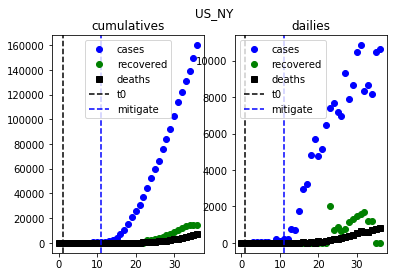

In [5]:
roi = "US_NY"

DF = pd.read_csv("../data/covid_timeseries_"+roi+".csv")

# pop = {}
# pop['Italy'] = 60500000
# pop['United Kingdom'] = 64400000
# pop['France'] = 66990000
# pop['Netherlands'] = 17000000

# mitigate = {}
# mitigate['Italy'] = '3/9/20' #approximate date
# mitigate['Netherlands'] = '3/12/20' #approximate date

# t0 := where to start time series, index space
t0 = np.where(DF["new_cases"].values>=10)[0][0] 
# tm := start of mitigation, index space
tm = t0 + 10 #np.where(mitigate[roi]==DF['dates2'])[0][0]

#plot the data with important time stamps (t0, tm)
plt.subplot(1,2,1)
plt.title('cumulatives')
plt.plot(DF["cum_cases"],'bo', label="cases")
plt.plot(DF["cum_recover"],'go',label="recovered")
plt.plot(DF["cum_deaths"],'ks',label="deaths")

plt.axvline(t0,color='k', linestyle="dashed", label='t0')
plt.axvline(tm,color='b', linestyle="dashed", label='mitigate')
plt.legend()


plt.subplot(1,2,2)
plt.title('dailies')
plt.plot(DF["new_cases"],'bo', label="cases")
plt.plot(DF["new_recover"],'go',label="recovered")
plt.plot(DF["new_deaths"],'ks',label="deaths")
plt.axvline(t0,color='k', linestyle="dashed", label='t0')
plt.axvline(tm,color='b', linestyle="dashed", label='mitigate')
plt.suptitle(roi)
plt.legend()


print("t0 index assumed to be: day "+str(t0))
print("t0 date: "+DF['dates2'][t0])
print("tm index assumed to be: day "+str(tm))
print("mitigation date: "+DF['dates2'][tm])



## Format JHU ROI data for Stan

In [6]:
# int<lower = 1> n_obs;       // number of days observed
# int<lower = 1> n_theta;     // number of model parameters
# int<lower = 1> n_difeq;     // number of differential equations for yhat
# int<lower = 1> n_ostates;     // number of observed states
# int<lower = 1> n_pop;       // population
# real<lower = 1> n_scale;       // scale to match observed scale
# int y[n_obs,n_ostates];           // data, per-day-tally [cases,recovered,death]
# real t0;                // initial time point 
# real tm; //start day of mitigation
# real ts[n_obs];         // time points that were observed
# int<lower = 1> n_obs_predict;       // number of days to predict
# real ts_predict[n_obs_predict];         // 

stan_data = {}

# stan_data['n_pop'] = pop[roi] 
stan_data['n_scale'] = 100000#10000000 #use this instead of population

stan_data['n_theta'] = 12
stan_data['n_difeq'] = 2
stan_data['n_ostates'] = 3

stan_data['t0'] = t0-1 #to for ODE is one day, index before start of series
stan_data['tm'] = tm
stan_data['ts'] = np.arange(t0,len(DF['dates2'])) 
DF = DF.replace('NaN', 0)
stan_data['y'] = (DF[['new_cases','new_recover','new_deaths']].to_numpy()).astype(int)[t0:,:]
stan_data['y'][stan_data['y']<0] = 0
stan_data['n_obs'] = len(DF['dates2']) - t0

#forward predict n days from t0
#returns uhat
# stan_data['ts_predict'] = np.arange(t0,len(DF['dates2'])+365)
# stan_data['n_obs_predict'] = len(DF['dates2']) - t0 + 365

### Print data for Stan 

In [7]:
# print(stan_data)

# Load England School 1978 Influenza data 

In [8]:
# #England 1978 influenza
# cases = [0,8,26,76,225,298,258,233,189,128,150,85,14,4]
# recovered = [0,0,0,0,9,17,105,162,176,166,150,85,47,20]
# plt.plot(cases,'bo', label="cases")
# plt.plot(recovered,'go',label="recovered")
# pop = 763
# model.stan_data['t0'] = 0
# #truncate time series from t0 on (initial is t0-1)
# model.stan_data['n_pop'] = pop 
# model.stan_data['ts'] = np.arange(1,len(cases)+1)  
# Y = np.hstack([np.c_[cases],np.c_[recovered],np.zeros((len(cases),1))]).astype(int)
# model.stan_data['y'] = Y
# model.stan_data['n_obs'] = len(cases)

# plt.plot(cases,'bo', label="cases")
# plt.plot(recovered,'go',label="recovered")

# plt.legend()

# Run Stan 

## Initialize parameters

In [9]:
# theta[1] ~ lognormal(log(0.25),1); //beta 
# theta[2] ~ lognormal(log(0.1),1); //sigmac
# theta[3] ~ lognormal(log(0.01),1); //sigmar
# theta[4] ~ lognormal(log(0.01),1); //sigmad
# theta[5] ~ lognormal(log(0.01),1); //q
# theta[6] ~ lognormal(log(1),1); //f
# theta[7] ~ lognormal(log(0.1),1); //mbase  
# theta[8] ~ lognormal(log(tm),5); //mlocation 
# theta[9] ~ lognormal(log(1),5); //mrate
# theta[10] ~ lognormal(log(0.1),1);//cmax 
# theta[11] ~ lognormal(log(10),1);//c50 
# theta[12] ~ lognormal(log(1),1);// theta_init 
init = [{'theta':[0.25,0.1,0.01,0.01,0.01,1.0,0.1,1.0,1.0,0.1,10.0,1.0]}]
    
def init_fun():
        x = {'theta':
             [np.random.lognormal(np.log(0.25),1)]+
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(0.01),1)]+
             [np.random.lognormal(np.log(0.01),1)]+
             [np.random.lognormal(np.log(0.01),1)]+
             [np.random.lognormal(np.log(1),1)]+
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(stan_data['tm']),5)]+
             [np.random.lognormal(np.log(1),5)]+
             [np.random.lognormal(np.log(0.1),1)]+
             [np.random.lognormal(np.log(10),1)]+
             [np.random.lognormal(np.log(1),0.1)]
            }
        return x


## Fit Stan 

In [ ]:
n_chains=6
n_warmups=1000
n_iter=10000
n_thin=50

control = {'adapt_delta':0.99}
fit = stanrunmodel.sampling(data = stan_data,init = init_fun ,control=control, chains = n_chains,chain_id=np.arange(n_chains), warmup = n_warmups, iter = n_iter, thin=n_thin, seed=13219)


In [18]:
import pickle
with open("./fits/model_fit"+roi+".pkl", "wb") as f:
    pickle.dump({'model' : stanrunmodel, 'fit' : fit}, f, protocol=-1)

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
#pystan.check_hmc_diagnostics(fit)

In [19]:
print(fit)

Inference for Stan model: anon_model_d538af0bacfe546a23ee0537cc246257.
6 chains, each with iter=5000; warmup=1000; thin=50; 
post-warmup draws per chain=80, total post-warmup draws=480.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]       2.08    0.67   1.22   0.61   0.86   1.71   3.54   4.19      3   3.48
theta[2]       0.47    0.18   0.38   0.07   0.08   0.69   0.83   0.88      4    2.3
theta[3]       0.02  2.0e-3 4.3e-3 9.2e-3   0.01   0.01   0.02   0.02      5   2.09
theta[4]       0.01  1.9e-3 3.8e-3 4.6e-3 6.3e-3   0.01   0.01   0.01      4   2.86
theta[5]     5.8e-3  1.3e-3 2.6e-3 4.4e-4 3.7e-3 7.4e-3 7.8e-3 8.1e-3      4   2.45
theta[6]       0.34  1.2e-3 2.4e-3   0.33   0.33   0.34   0.34   0.34      4   4.43
theta[7]       0.06  3.4e-4 6.4e-4   0.06   0.06   0.06   0.06   0.06      4    4.5
theta[8]       1.56  8.7e-3   0.02   1.54   1.54   1.56   1.57   1.59      3   3.51
theta[9]     3.0e-4  6.9e-6 1.3e-5 2.9e-4 2.9e-4 2.9e-4 3

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1327cb7d0>,
      dtype=object)

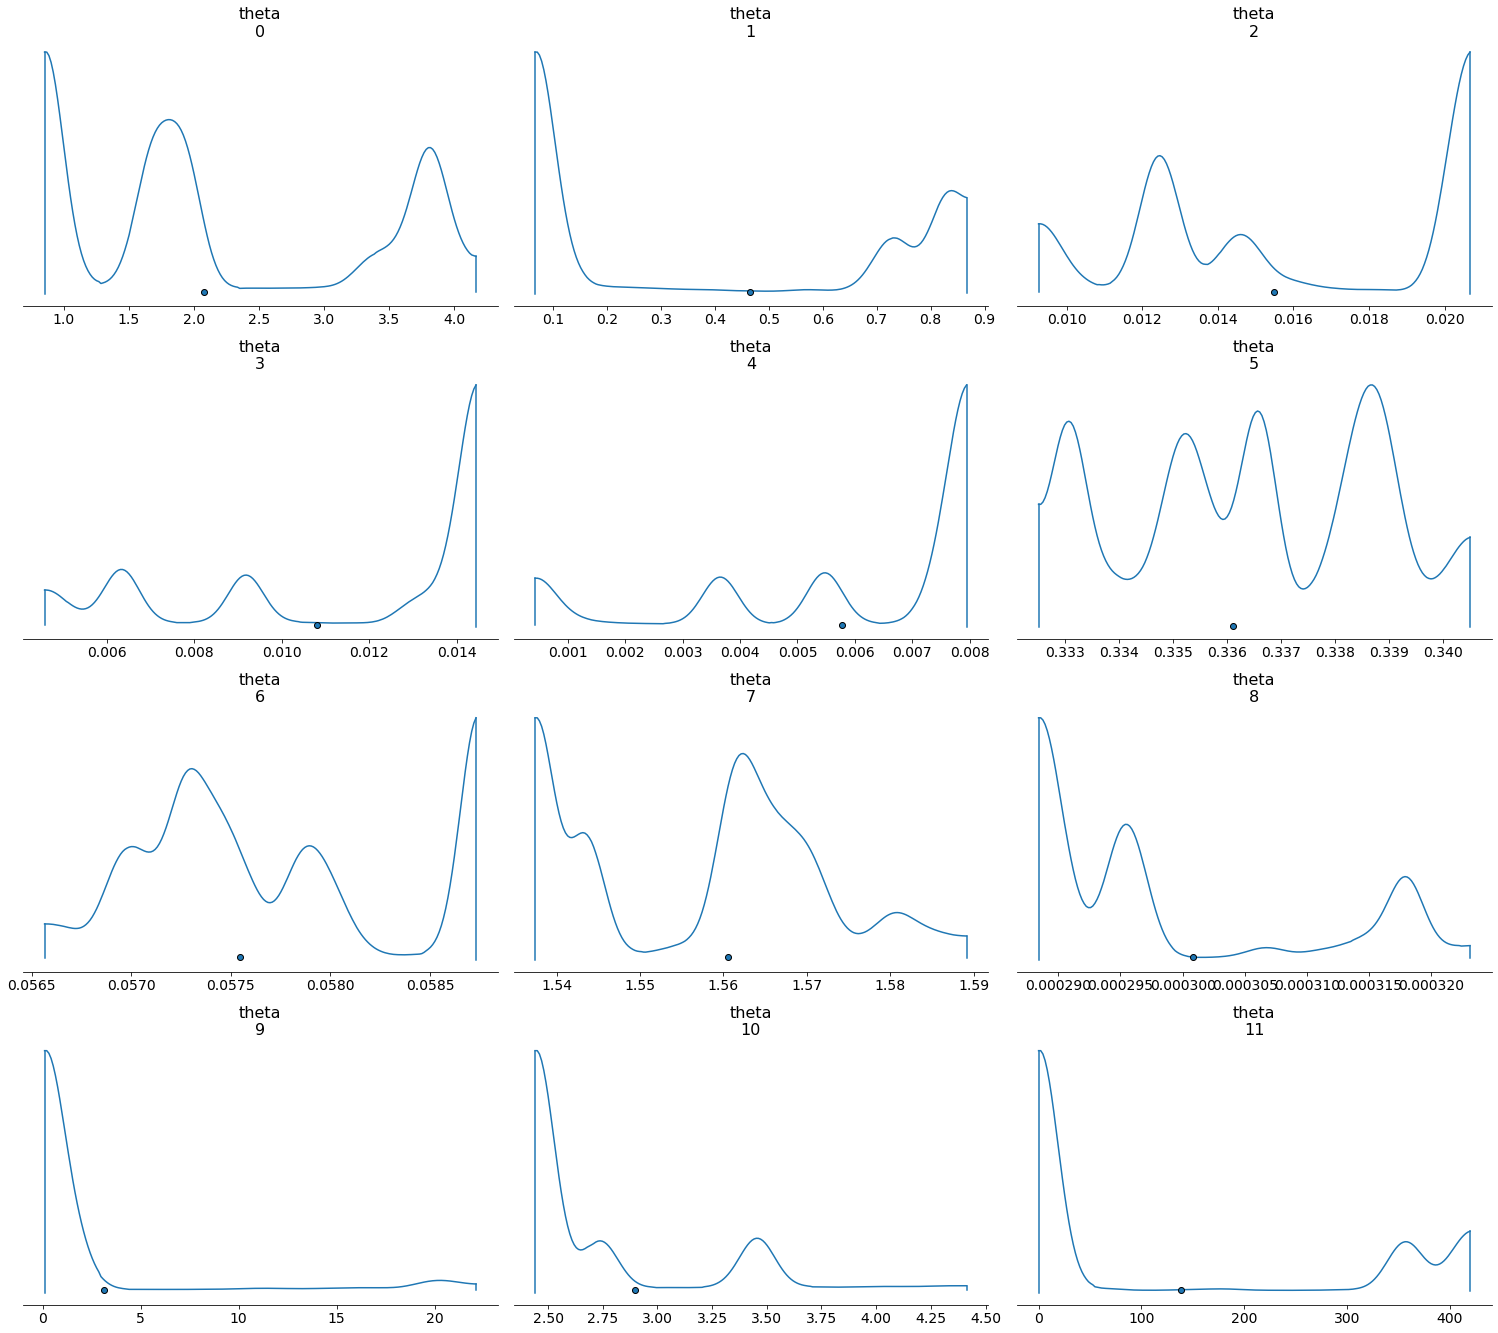

In [20]:
#https://arviz-devs.github.io/arviz/generated/arviz.plot_density
az.plot_density(fit,group='posterior',var_names=["theta"])

(480, 36, 2)
(480, 12)


(0, 10000)

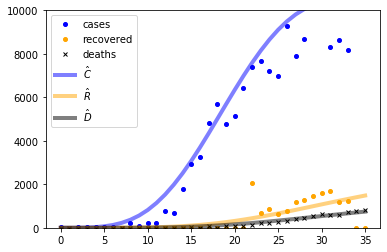

In [21]:
print(np.shape(fit.extract()['u']))
n,t,p = np.shape(fit.extract()['u'])
print(np.shape(fit.extract()['theta']))

ms=4

x = range(len(DF["new_cases"][t0:]))
     
plt.plot(x,DF["new_cases"][t0:],'bo', label="cases",ms=ms)
plt.plot(x,DF["new_recover"][t0:],'o',color='orange',label="recovered",ms=ms)
plt.plot(x,DF["new_deaths"][t0:],'x',color='k',label="deaths",ms=ms)
  
lw=4
alpha = 0.5


beta = fit.extract()['theta'][-1,0]
sigmac = fit.extract()['theta'][-1,1]
sigmar = fit.extract()['theta'][-1,2]
sigmad =  fit.extract()['theta'][-1,3]
q = fit.extract()['theta'][-1,4]
f = fit.extract()['theta'][-1,5] 
mbase = fit.extract()['theta'][-1,6] 
mlocation = fit.extract()['theta'][-1,7] 
mrate = fit.extract()['theta'][-1,8]
cmax = fit.extract()['theta'][-1,9]
c50 = fit.extract()['theta'][-1,10]
theta_init = fit.extract()['theta'][-1,11]


t = np.arange(t)
sigmac *= 1 + cmax*t/(c50+t)

Chat = stan_data['n_scale']*sigmac*fit.extract()['u'][-1,:,0]
Rhat = stan_data['n_scale']*sigmar*fit.extract()['u'][-1,:,1]
Dhat = stan_data['n_scale']*sigmad*fit.extract()['u'][-1,:,1]
plt.plot(Chat,label=r'$\hat{C}$',lw=lw,alpha=alpha,color='b')
plt.plot(Rhat,label=r'$\hat{R}$',lw=lw,alpha=alpha,color='orange')
plt.plot(Dhat,label=r'$\hat{D}$',lw=lw,alpha=alpha,color='k')

plt.legend()
plt.ylim((0,10000))
